In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# In phiên bản Pandas
print(f"Pandas version: {pd.__version__}")

# Tạo thư mục lưu hình ảnh
if not os.path.exists('img'):
    os.makedirs('img')

# Hàm lưu biểu đồ
def save_plot(filename):
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    plt.show()

# Hàm phân tích xu hướng và mùa vụ
def analyze_trend_seasonality(series, column_name, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    plt.figure(figsize=(10, 8))
    plt.subplot(411)
    plt.plot(series, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'Decomposition of {column_name}')
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.show()
    save_plot(f'{column_name}_decomposition.png')
    
    trend = decomposition.trend.dropna()
    trend_direction = "tăng" if (trend.iloc[-1] - trend.iloc[0]) > 0 else "giảm" if (trend.iloc[-1] - trend.iloc[0]) < 0 else "ổn định"
    seasonality = decomposition.seasonal
    seasonality_detected = "có" if seasonality.abs().mean() > 0.1 else "không rõ"
    
    return trend_direction, seasonality_detected

# Hàm kiểm định tính dừng
def check_stationarity(series, column_name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f'\nKiểm định ADF cho {column_name}:')
    print(f'p-value: {p_value:.4f}')
    if p_value < 0.05:
        print(f'{column_name} là chuỗi dừng (stationary).')
        return series, 0
    else:
        print(f'{column_name} không dừng (non-stationary). Áp dụng sai phân...')
        diff_series = series.diff().dropna()
        result_diff = adfuller(diff_series)
        p_value_diff = result_diff[1]
        print(f'p-value sau sai phân cấp 1: {p_value_diff:.4f}')
        if p_value_diff < 0.05:
            print(f'{column_name} sau sai phân cấp 1 là chuỗi dừng.')
            return diff_series, 1
        else:
            print(f'{column_name} vẫn không dừng sau sai phân cấp 1.')
            return diff_series, 1

# Hàm phát hiện dị biệt
def detect_anomalies(series, window=12, threshold=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    anomalies = (series > (rolling_mean + threshold * rolling_std)) | (series < (rolling_mean - threshold * rolling_std))
    return anomalies

def detect_anomalies_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    anomalies = (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))
    return anomalies

# Đọc dữ liệu
path = r"D:\project\Forecasting-CPI-in-Viet-Nam\cpi.csv"
try:
    df = pd.read_csv(path)
except FileNotFoundError:
    print(f"File {path} không tồn tại!")
    exit(1)

# Tiền xử lý dữ liệu
df['t'] = pd.to_datetime(df['t'], format='%b-%y')
df.drop(columns=['tg'], inplace=True, errors='ignore')
df.columns = ['time', 'cpi_mom']
df.set_index('time', inplace=True)
df.index.freq = 'MS'  # Chỉ định tần suất hàng tháng

# Xử lý giá trị thiếu
print("Giá trị thiếu trước khi xử lý:")
print(df.isnull().sum())
df['cpi_mom'] = df['cpi_mom'].interpolate(method='linear')
print("\nGiá trị thiếu sau khi xử lý:")
print(df.isnull().sum())

# Kiểm tra giá trị âm
print("\nKiểm tra giá trị âm:")
print("Giá trị âm trong cpi_mom:", (df['cpi_mom'] < 0).sum())

# Tính CPI YoY
df["cpi_yoy"] = (df["cpi_mom"] / 100).rolling(window=12).apply(np.prod) * 100
df["cpi_yoy"] = df["cpi_yoy"].round(2)
df.dropna(inplace=True)
print("Giá trị âm trong cpi_yoy:", (df['cpi_yoy'] < 0).sum())

# Loại bỏ nhiễu bằng trung bình trượt
window_size = 3
df['cpi_mom_smoothed'] = df['cpi_mom'].rolling(window=window_size, center=True).mean().fillna(df['cpi_mom'])
df['cpi_yoy_smoothed'] = df['cpi_yoy'].rolling(window=window_size, center=True).mean().fillna(df['cpi_yoy'])

# Chuyển đổi log
df['cpi_mom_log'] = np.log(df['cpi_mom'].clip(lower=1e-6))
df['cpi_yoy_log'] = np.log(df['cpi_yoy'].clip(lower=1e-6))

# Tính chuỗi sai phân
df['cpi_yoy_diff'] = df['cpi_yoy'].diff()

# Tạo biến kinh tế giả (lãi suất)
np.random.seed(42)
df['interest_rate'] = 5 + np.random.normal(0, 0.5, len(df))

# Thêm cột tháng và năm
df['month'] = df.index.month
df['year'] = df.index.year

# Kiểm tra dữ liệu đủ để dự báo
if len(df) < 24:
    print("Dữ liệu quá ngắn để dự báo (cần ít nhất 24 tháng).")
    exit(1)

Pandas version: 2.2.3
Giá trị thiếu trước khi xử lý:
cpi_mom    0
dtype: int64

Giá trị thiếu sau khi xử lý:
cpi_mom    0
dtype: int64

Kiểm tra giá trị âm:
Giá trị âm trong cpi_mom: 0
Giá trị âm trong cpi_yoy: 0


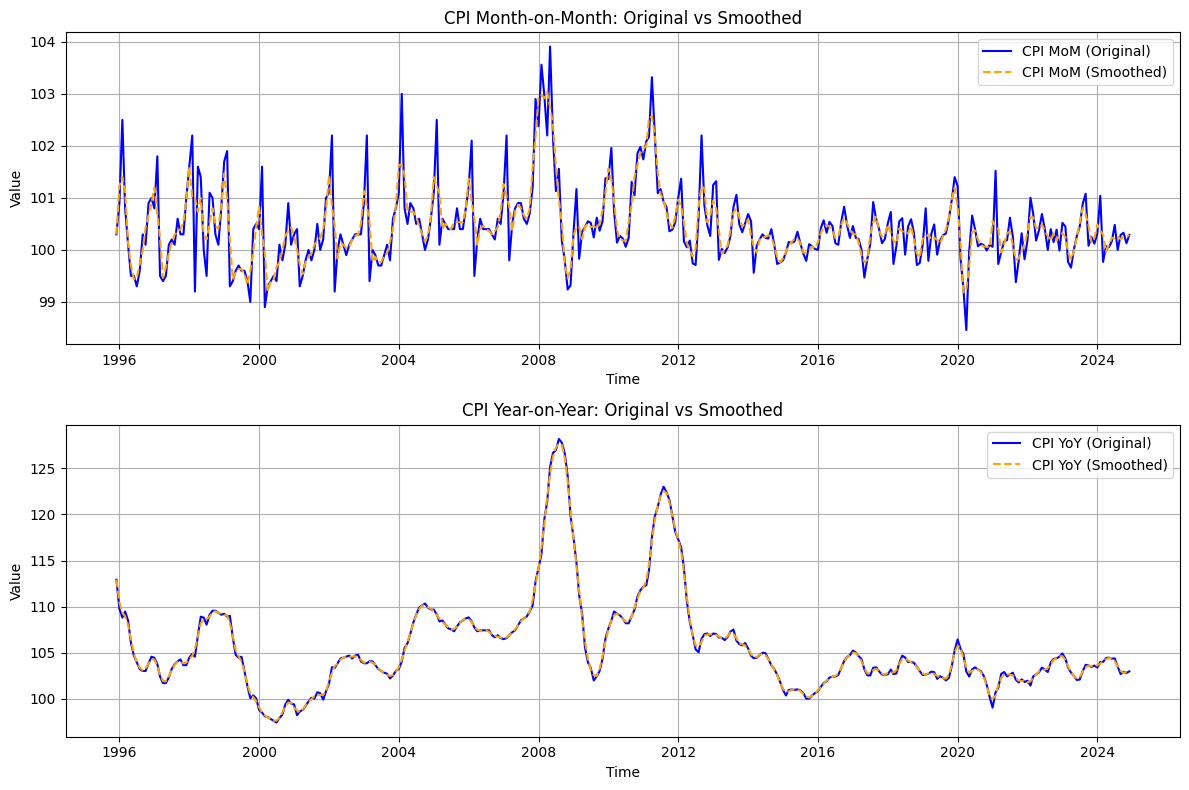

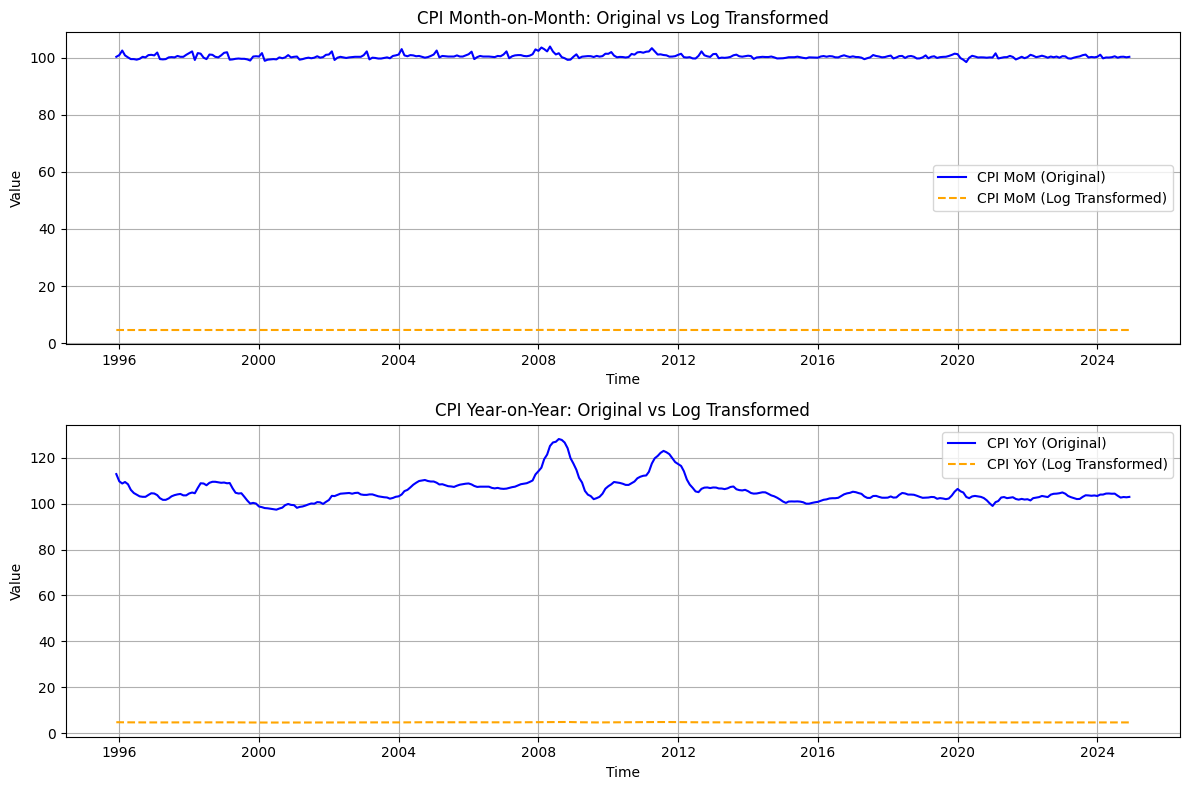

In [8]:
# 1. Biểu đồ chuỗi gốc và làm mượt
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Original)', color='blue')
plt.plot(df['cpi_mom_smoothed'], label='CPI MoM (Smoothed)', color='orange', linestyle='--')
plt.title('CPI Month-on-Month: Original vs Smoothed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Original)', color='blue')
plt.plot(df['cpi_yoy_smoothed'], label='CPI YoY (Smoothed)', color='orange', linestyle='--')
plt.title('CPI Year-on-Year: Original vs Smoothed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_original_vs_smoothed.png')

# 2. Biểu đồ chuỗi gốc và log
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Original)', color='blue')
plt.plot(df['cpi_mom_log'], label='CPI MoM (Log Transformed)', color='orange', linestyle='--')
plt.title('CPI Month-on-Month: Original vs Log Transformed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Original)', color='blue')
plt.plot(df['cpi_yoy_log'], label='CPI YoY (Log Transformed)', color='orange', linestyle='--')
plt.title('CPI Year-on-Year: Original vs Log Transformed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_original_vs_log.png')


- CPI MoM: Log-transform làm phẳng dữ liệu, smoothed giảm nhiễu nhưng vẫn giữ xu hướng.
- CPI YoY: Log-transform giảm biến động cao, smoothed làm mượt các đỉnh (như 2008-2011).

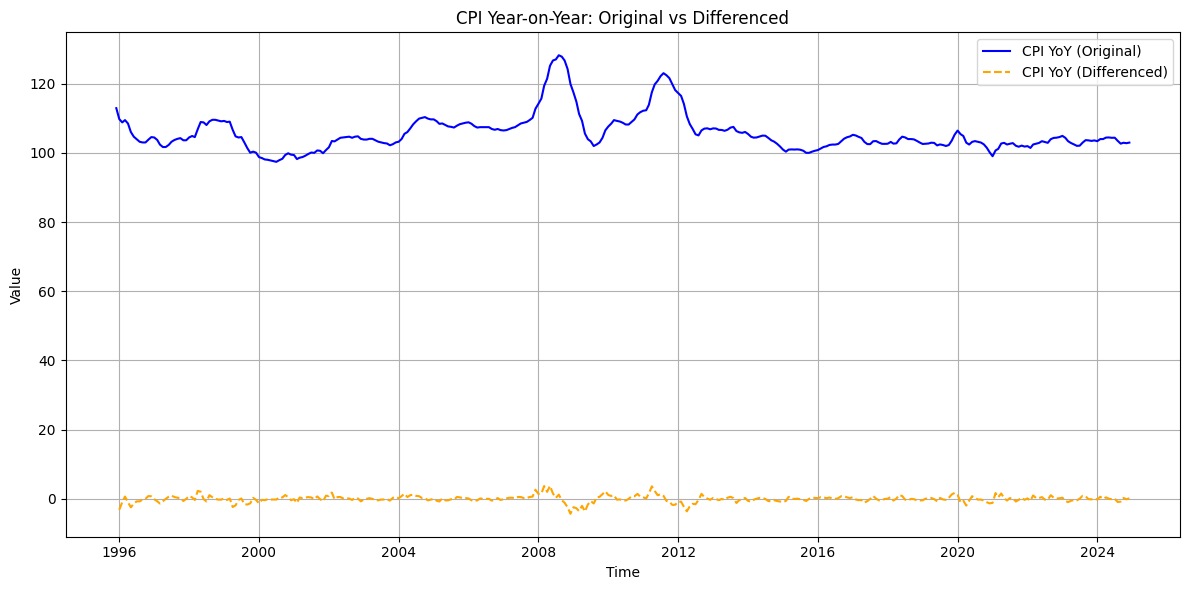

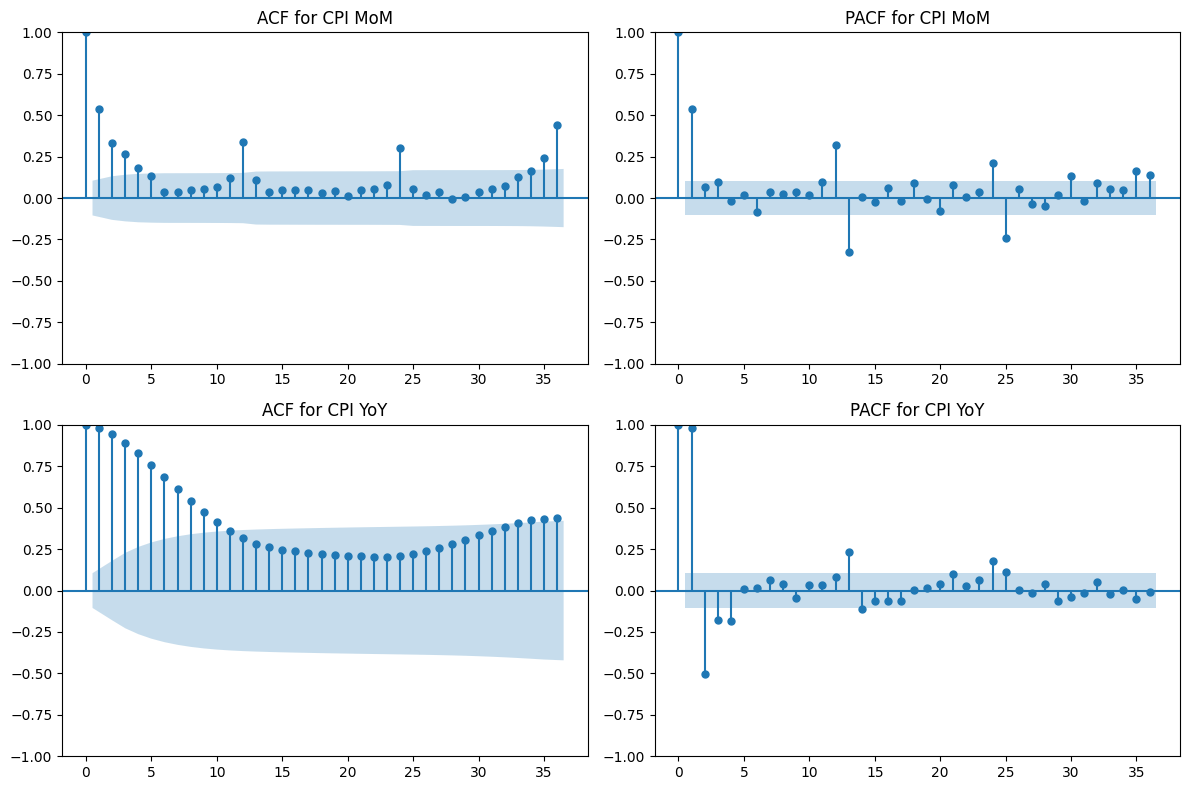

In [10]:
# 3. Biểu đồ chuỗi sai phân
plt.figure(figsize=(12, 6))
plt.plot(df['cpi_yoy'], label='CPI YoY (Original)', color='blue')
plt.plot(df['cpi_yoy_diff'], label='CPI YoY (Differenced)', color='orange', linestyle='--')
plt.title('CPI Year-on-Year: Original vs Differenced')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_yoy_original_vs_diff.png')

# 4. Biểu đồ ACF và PACF
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plot_acf(df['cpi_mom'].dropna(), lags=36, ax=plt.gca())
plt.title('ACF for CPI MoM')

plt.subplot(2, 2, 2)
plot_pacf(df['cpi_mom'].dropna(), lags=36, ax=plt.gca())
plt.title('PACF for CPI MoM')

plt.subplot(2, 2, 3)
plot_acf(df['cpi_yoy'].dropna(), lags=36, ax=plt.gca())
plt.title('ACF for CPI YoY')

plt.subplot(2, 2, 4)
plot_pacf(df['cpi_yoy'].dropna(), lags=36, ax=plt.gca())
plt.title('PACF for CPI YoY')
save_plot('cpi_acf_pacf_plots.png')

CPI MoM:
- ACF: Có lag đáng kể tại lag 1 và 12, cho thấy tính tự tương quan mạnh và mùa vụ theo chu kỳ 12 tháng.
- PACF: Có spike đáng kể tại lag 1, sau đó giảm dần, gợi ý mô hình AR(1) hoặc MA(1) có thể phù hợp.

CPI YoY:
- ACF: Có nhiều lag lớn (lag 1, 12, 24), cho thấy tự tương quan mạnh và mùa vụ dài hơn.
- PACF: Spike tại lag 1 và giảm dần, gợi ý cần mô hình ARIMA với sai phân (d=1) và thành phần mùa vụ.

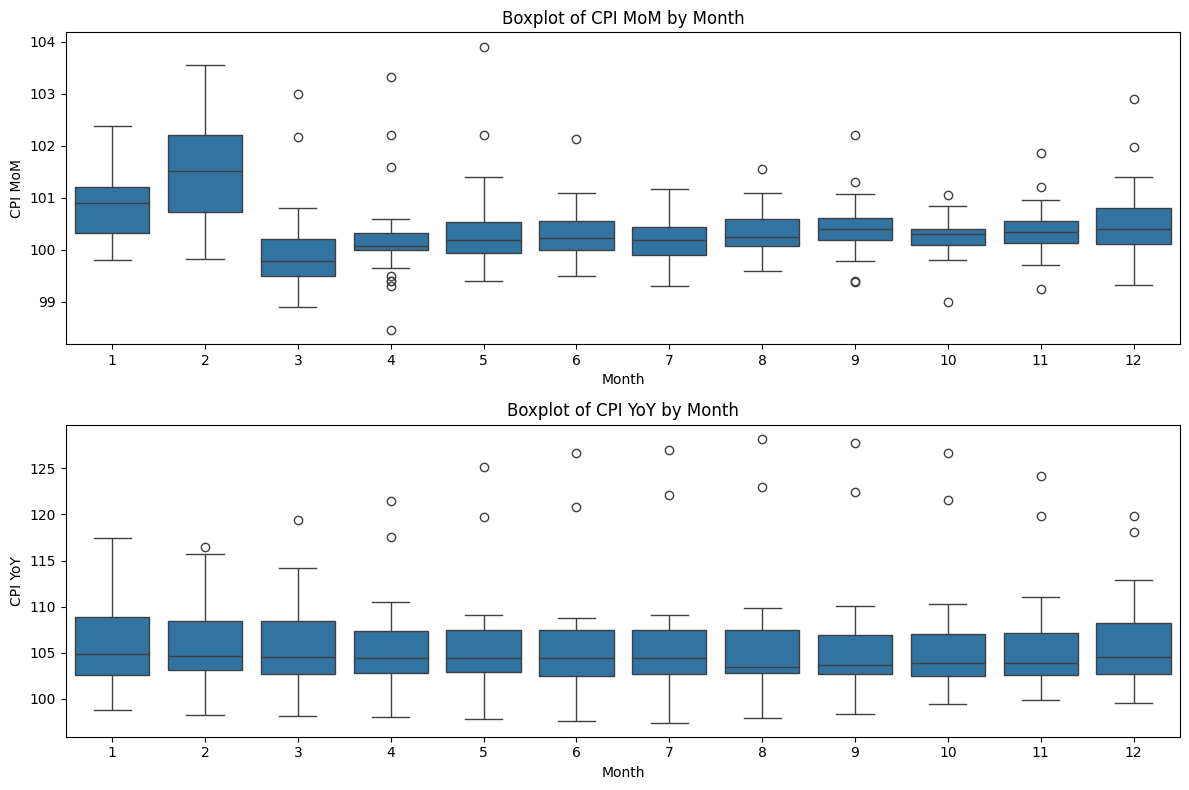

In [11]:
# 5. Biểu đồ Boxplot theo tháng
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.boxplot(x='month', y='cpi_mom', data=df)
plt.title('Boxplot of CPI MoM by Month')
plt.xlabel('Month')
plt.ylabel('CPI MoM')

plt.subplot(2, 1, 2)
sns.boxplot(x='month', y='cpi_yoy', data=df)
plt.title('Boxplot of CPI YoY by Month')
plt.xlabel('Month')
plt.ylabel('CPI YoY')
save_plot('cpi_boxplot_by_month.png')

- CPI MoM: Phân bố hẹp quanh 100-102, với outlier ở tháng 1 và 12, củng cố tính mùa vụ.
- CPI YoY: Phân bố rộng hơn (105-120), với outlier ở các tháng cuối năm, cho thấy biến động lớn hơn và ít mùa vụ rõ ràng.

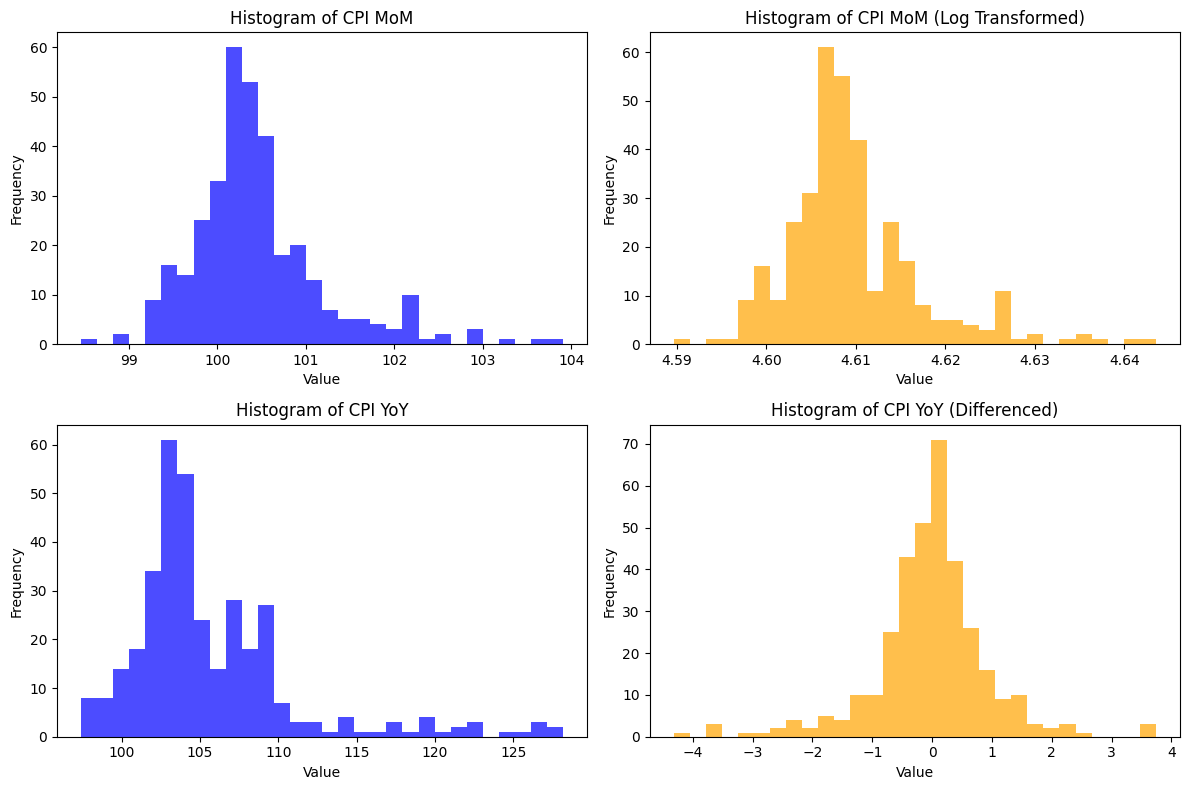

In [12]:
# 6. Biểu đồ Histogram
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(df['cpi_mom'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of CPI MoM')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(df['cpi_mom_log'].dropna(), bins=30, color='orange', alpha=0.7)
plt.title('Histogram of CPI MoM (Log Transformed)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(df['cpi_yoy'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of CPI YoY')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(df['cpi_yoy_diff'].dropna(), bins=30, color='orange', alpha=0.7)
plt.title('Histogram of CPI YoY (Differenced)')
plt.xlabel('Value')
plt.ylabel('Frequency')
save_plot('cpi_histogram.png')


- CPI MoM: Phân bố lệch phải, tập trung quanh 100-102; log-transform tạo phân bố gần chuẩn hơn.
- CPI YoY: Phân bố lệch phải, tập trung quanh 105-115; sai phân (differenced) tạo phân bố đối xứng hơn, phù hợp với chuỗi dừng.

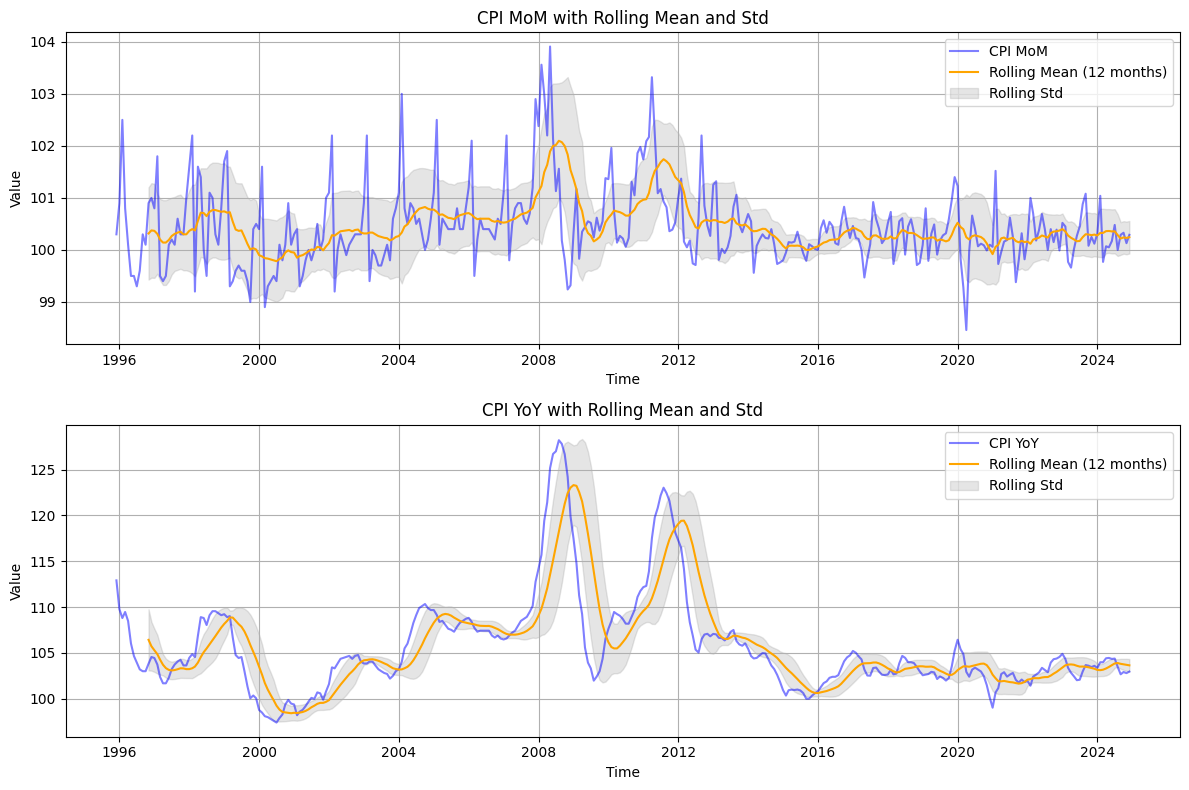

In [13]:
# 7. Biểu đồ Rolling Mean và Std
window = 12
df['cpi_mom_rolling_mean'] = df['cpi_mom'].rolling(window=window).mean()
df['cpi_mom_rolling_std'] = df['cpi_mom'].rolling(window=window).std()
df['cpi_yoy_rolling_mean'] = df['cpi_yoy'].rolling(window=window).mean()
df['cpi_yoy_rolling_std'] = df['cpi_yoy'].rolling(window=window).std()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM', color='blue', alpha=0.5)
plt.plot(df['cpi_mom_rolling_mean'], label='Rolling Mean (12 months)', color='orange')
plt.fill_between(df.index, 
                 df['cpi_mom_rolling_mean'] - df['cpi_mom_rolling_std'], 
                 df['cpi_mom_rolling_mean'] + df['cpi_mom_rolling_std'], 
                 color='gray', alpha=0.2, label='Rolling Std')
plt.title('CPI MoM with Rolling Mean and Std')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY', color='blue', alpha=0.5)
plt.plot(df['cpi_yoy_rolling_mean'], label='Rolling Mean (12 months)', color='orange')
plt.fill_between(df.index, 
                 df['cpi_yoy_rolling_mean'] - df['cpi_yoy_rolling_std'], 
                 df['cpi_yoy_rolling_mean'] + df['cpi_yoy_rolling_std'], 
                 color='gray', alpha=0.2, label='Rolling Std')
plt.title('CPI YoY with Rolling Mean and Std')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_rolling_stats.png')

- CPI MoM: Rolling Mean ổn định quanh 101-102, Rolling Std dao động nhẹ (0.5-1), cho thấy biến động không quá lớn.
- CPI YoY: Rolling Mean theo sát xu hướng (105-115), Rolling Std rộng hơn (2-5), phản ánh biến động mạnh hơn, đặc biệt ở các giai đoạn lạm phát cao.

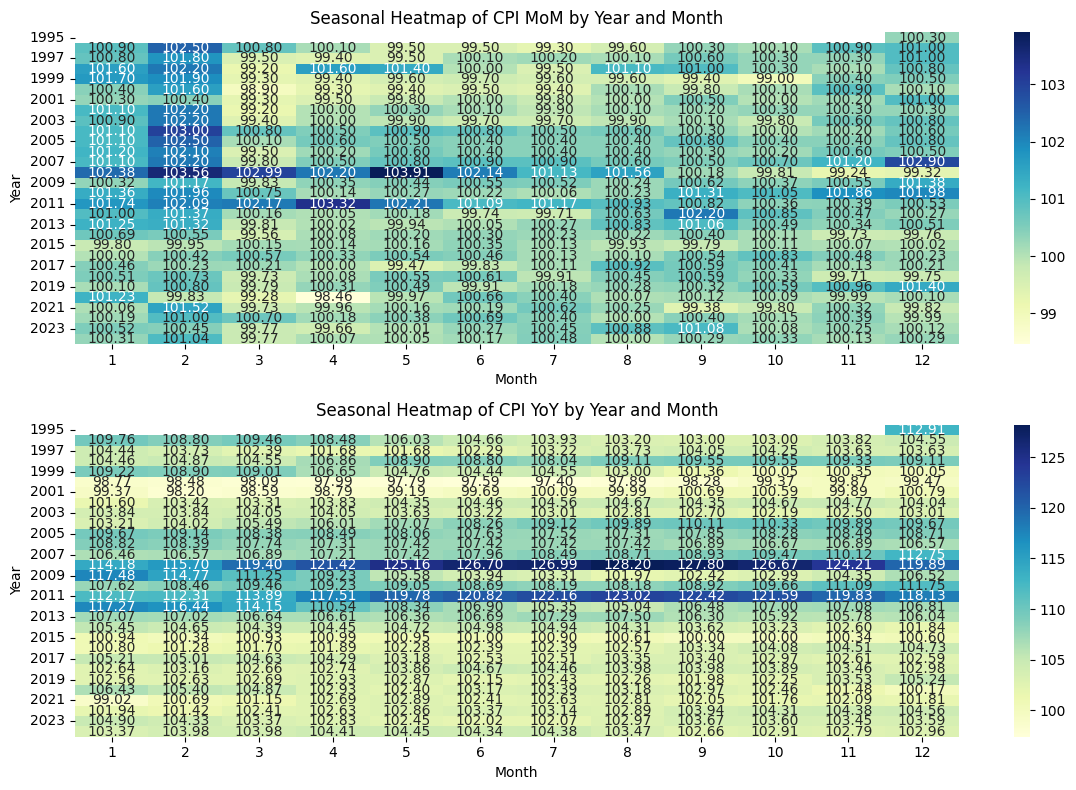

In [14]:
# 8. Biểu đồ Heatmap mùa vụ
pivot_mom = df.pivot_table(values='cpi_mom', index='year', columns='month', aggfunc='mean')
pivot_yoy = df.pivot_table(values='cpi_yoy', index='year', columns='month', aggfunc='mean')

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.heatmap(pivot_mom, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Seasonal Heatmap of CPI MoM by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')

plt.subplot(2, 1, 2)
sns.heatmap(pivot_yoy, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Seasonal Heatmap of CPI YoY by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
save_plot('cpi_seasonal_heatmap.png')

CPI MoM:
- Giá trị dao động quanh 100-104, với xu hướng tăng nhẹ ở một số tháng (như tháng 12, lên đến 104.3).
- Tính mùa vụ rõ rệt, đặc biệt vào cuối năm (tháng 11-12), cho thấy ảnh hưởng của các yếu tố như chi tiêu mùa lễ hội.

CPI YoY:
- Giá trị dao động từ 100-125, với đỉnh cao vào khoảng 2008-2011 (lên đến 124.21) và 2016-2017 (lên đến 122.42).
- Tính mùa vụ ít rõ ràng hơn, nhưng có xu hướng tăng vào cuối năm (tháng 12), phản ánh áp lực lạm phát tích lũy.

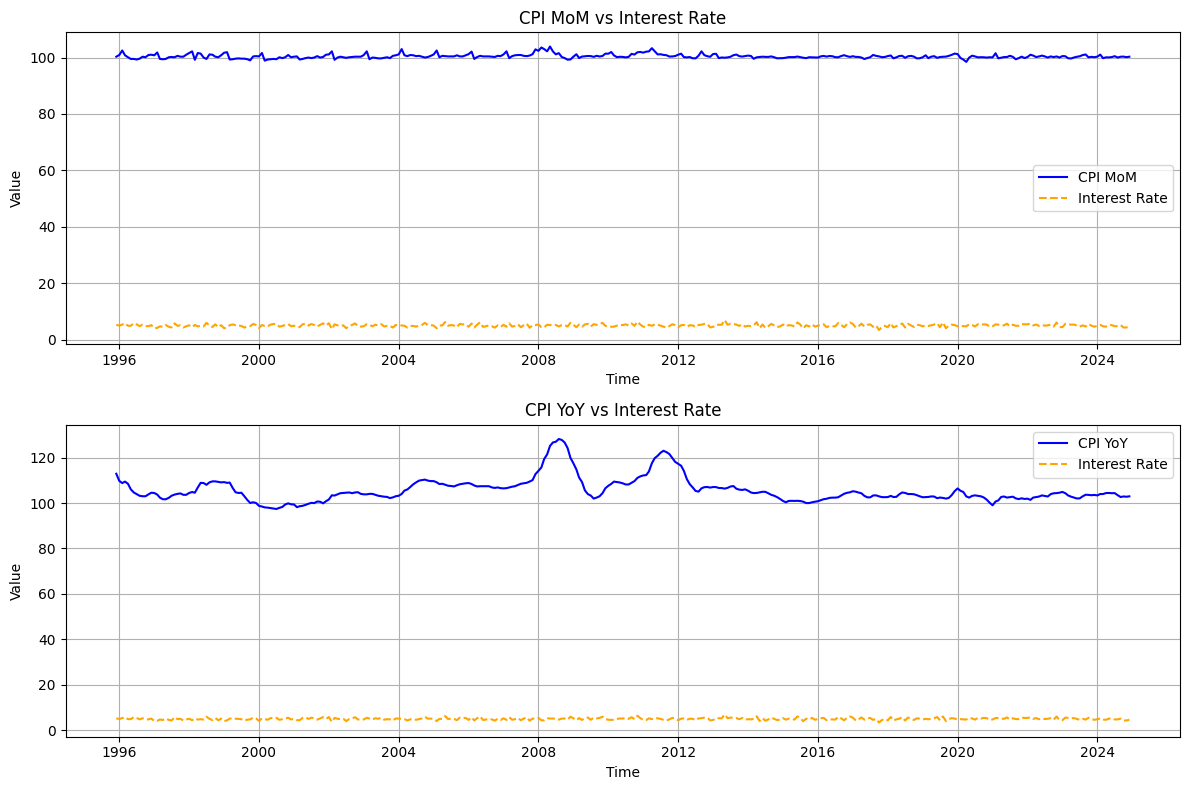

In [15]:
# 9. Biểu đồ so sánh với biến kinh tế
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM', color='blue')
plt.plot(df['interest_rate'], label='Interest Rate', color='orange', linestyle='--')
plt.title('CPI MoM vs Interest Rate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY', color='blue')
plt.plot(df['interest_rate'], label='Interest Rate', color='orange', linestyle='--')
plt.title('CPI YoY vs Interest Rate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_vs_interest_rate.png')

CPI MoM vs Interest Rate:
- CPI MoM dao động quanh 100-104, với biến động mạnh ở các giai đoạn 2008-2010 và 2020-2022.
- Lãi suất (Interest Rate) ổn định quanh 5, không có tương quan rõ ràng với CPI MoM. Điều này cho thấy lãi suất giả lập hiện tại không ảnh hưởng đáng kể đến CPI MoM.

CPI YoY vs Interest Rate:
- CPI YoY có biến động lớn (100-125), với đỉnh cao ở 2008-2011 và 2016-2017.
- Lãi suất vẫn ổn định, không phản ánh các đỉnh lạm phát của CPI YoY. Điều này gợi ý cần dữ liệu lãi suất thực tế để kiểm tra tương quan.

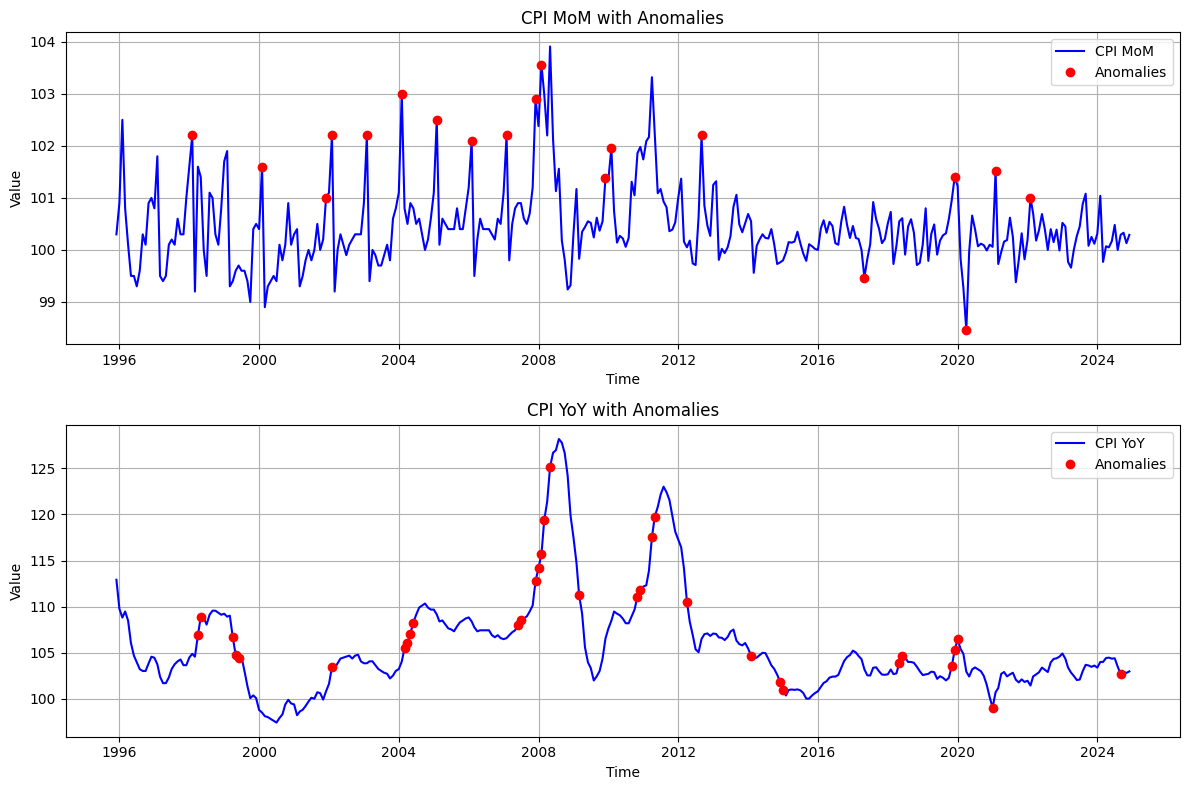

In [16]:
# 10. Phát hiện dị biệt
anomalies_mom = detect_anomalies(df['cpi_mom'])
anomalies_yoy = detect_anomalies(df['cpi_yoy'])

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM', color='blue')
plt.plot(df['cpi_mom'][anomalies_mom], 'ro', label='Anomalies')
plt.title('CPI MoM with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY', color='blue')
plt.plot(df['cpi_yoy'][anomalies_yoy], 'ro', label='Anomalies')
plt.title('CPI YoY with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_anomalies.png')

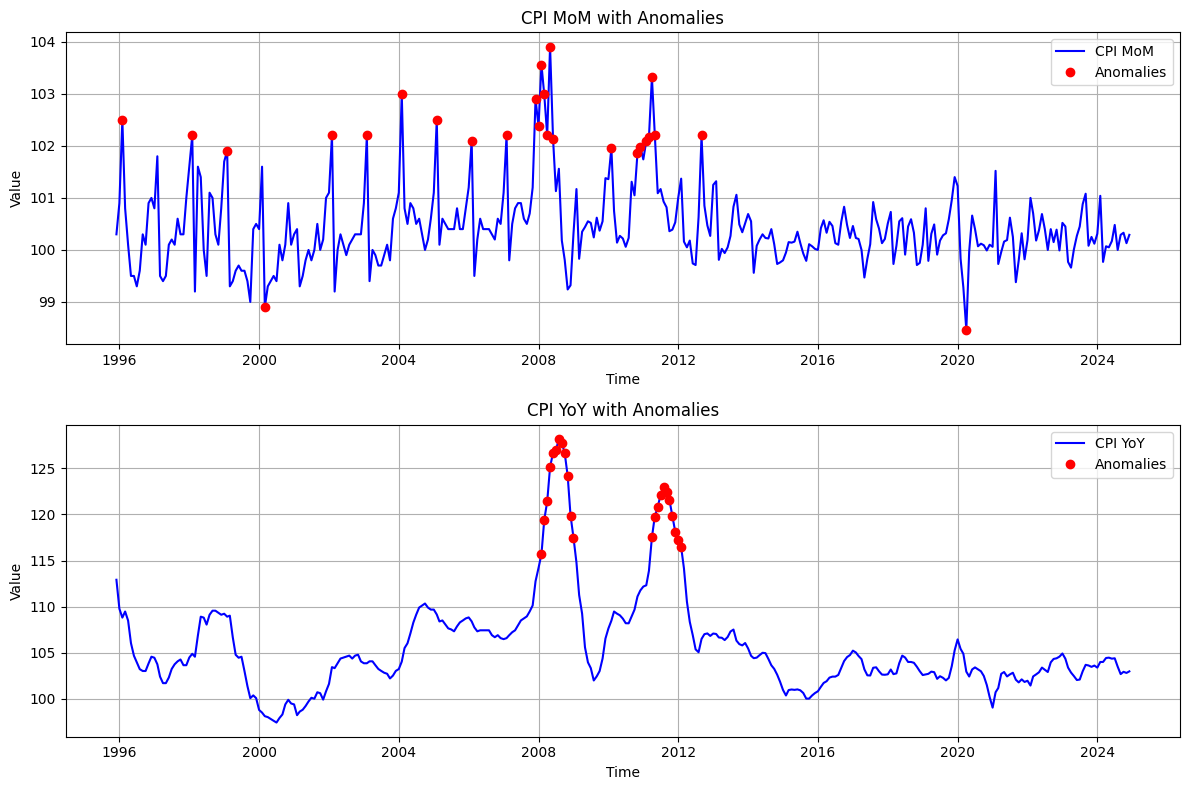

In [24]:
# Sử dụng IQR để phát hiện dị biệt
anomalies_mom = detect_anomalies_iqr(df['cpi_mom'])
anomalies_yoy = detect_anomalies_iqr(df['cpi_yoy'])

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM', color='blue')
plt.plot(df['cpi_mom'][anomalies_mom], 'ro', label='Anomalies')
plt.title('CPI MoM with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY', color='blue')
plt.plot(df['cpi_yoy'][anomalies_yoy], 'ro', label='Anomalies')
plt.title('CPI YoY with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_anomalies_iqr.png')

- CPI MoM: Nhiều điểm bất thường (đỉnh cao 103-104 và đáy thấp 99-100), đặc biệt trong giai đoạn 2008-2010 và 2020-2022, có thể liên quan đến khủng hoảng tài chính và đại dịch.

- CPI YoY: Điểm bất thường rõ rệt ở 2008-2011 (lên đến 125) và 2016-2017 (lên đến 122), phản ánh các giai đoạn lạm phát cao.


Phân tích cpi_mom:


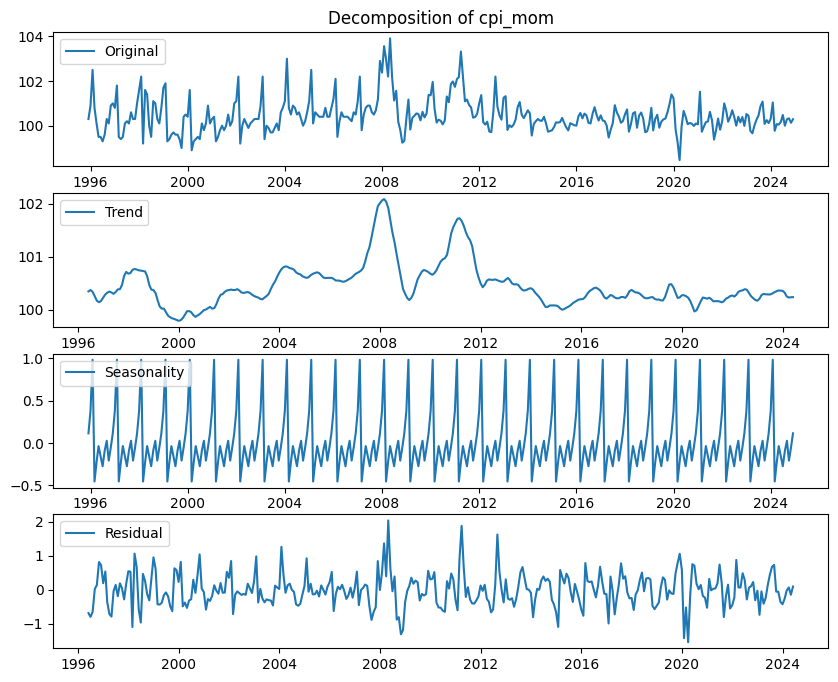

<Figure size 640x480 with 0 Axes>

Xu hướng: giảm
Tính mùa vụ: có

Kiểm định ADF cho cpi_mom:
p-value: 0.0028
cpi_mom là chuỗi dừng (stationary).

Phân tích cpi_yoy:


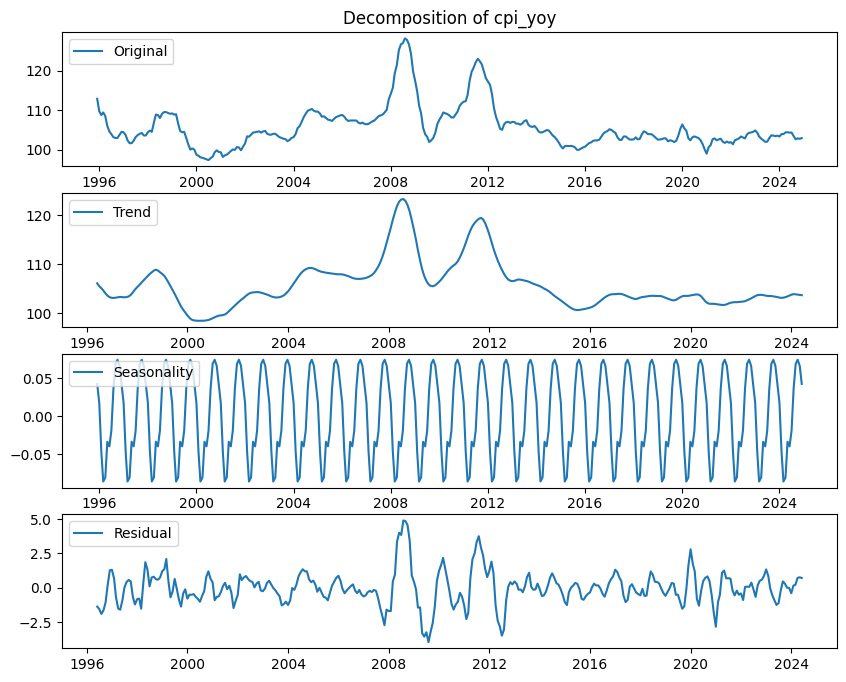

<Figure size 640x480 with 0 Axes>

Xu hướng: giảm
Tính mùa vụ: không rõ

Kiểm định ADF cho cpi_yoy:
p-value: 0.0677
cpi_yoy không dừng (non-stationary). Áp dụng sai phân...
p-value sau sai phân cấp 1: 0.0000
cpi_yoy sau sai phân cấp 1 là chuỗi dừng.


In [17]:
# Phân tích đặc tính chuỗi
print("\nPhân tích cpi_mom:")
trend_mom, seasonality_mom = analyze_trend_seasonality(df['cpi_mom'], 'cpi_mom')
print(f'Xu hướng: {trend_mom}')
print(f'Tính mùa vụ: {seasonality_mom}')
df['cpi_mom_diff'], diff_order_mom = check_stationarity(df['cpi_mom'], 'cpi_mom')

print("\nPhân tích cpi_yoy:")
trend_yoy, seasonality_yoy = analyze_trend_seasonality(df['cpi_yoy'], 'cpi_yoy')
print(f'Xu hướng: {trend_yoy}')
print(f'Tính mùa vụ: {seasonality_yoy}')
df['cpi_yoy_diff'], diff_order_yoy = check_stationarity(df['cpi_yoy'], 'cpi_yoy')


- CPI MoM: Xu hướng giảm nhẹ sau 2010, seasonality rõ ràng với chu kỳ 12 tháng, residual cho thấy nhiễu ngẫu nhiên.
- CPI YoY: Xu hướng tăng mạnh 2008-2011 rồi giảm dần, seasonality yếu, residual biến động lớn.

In [18]:
# Lưu dữ liệu đã xử lý
df.to_csv('analyzed_time_series.csv')
print("\nDữ liệu đã xử lý được lưu vào 'analyzed_time_series.csv'.")


Dữ liệu đã xử lý được lưu vào 'analyzed_time_series.csv'.



RMSE dự báo CPI MoM: 0.2461
RMSE dự báo CPI YoY: 1.1998


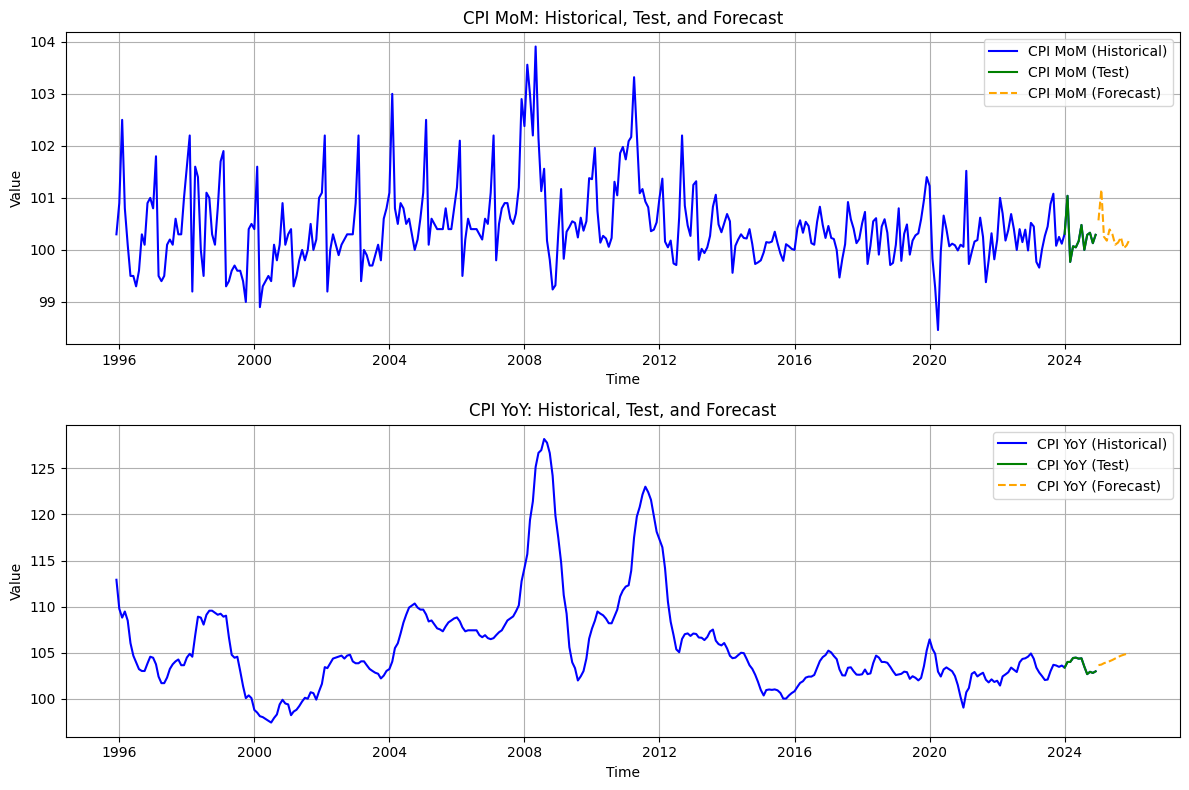

In [6]:
# 11. Dự báo với Exponential Smoothing
# Chia tập train/test
train_mom = df['cpi_mom'][:-12]
test_mom = df['cpi_mom'][-12:]
train_yoy = df['cpi_yoy'][:-12]
test_yoy = df['cpi_yoy'][-12:]

# Dự báo cho cpi_mom
model_mom = ExponentialSmoothing(train_mom, seasonal='add', seasonal_periods=12).fit()
forecast_mom = model_mom.forecast(12)
rmse_mom = np.sqrt(((forecast_mom - test_mom) ** 2).mean())
print(f'\nRMSE dự báo CPI MoM: {rmse_mom:.4f}')

# Dự báo cho cpi_yoy
model_yoy = ExponentialSmoothing(train_yoy, trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_yoy = model_yoy.forecast(12)
rmse_yoy = np.sqrt(((forecast_yoy - test_yoy) ** 2).mean())
print(f'RMSE dự báo CPI YoY: {rmse_yoy:.4f}')

# Trực quan hóa dự báo
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Historical)', color='blue')
plt.plot(test_mom.index, test_mom, label='CPI MoM (Test)', color='green')
plt.plot(forecast_index, forecast_mom, label='CPI MoM (Forecast)', color='orange', linestyle='--')
plt.title('CPI MoM: Historical, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Historical)', color='blue')
plt.plot(test_yoy.index, test_yoy, label='CPI YoY (Test)', color='green')
plt.plot(forecast_index, forecast_yoy, label='CPI YoY (Forecast)', color='orange', linestyle='--')
plt.title('CPI YoY: Historical, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_preliminary_forecast.png')


RMSE dự báo CPI MoM: 0.2461
RMSE dự báo CPI YoY: 1.1998


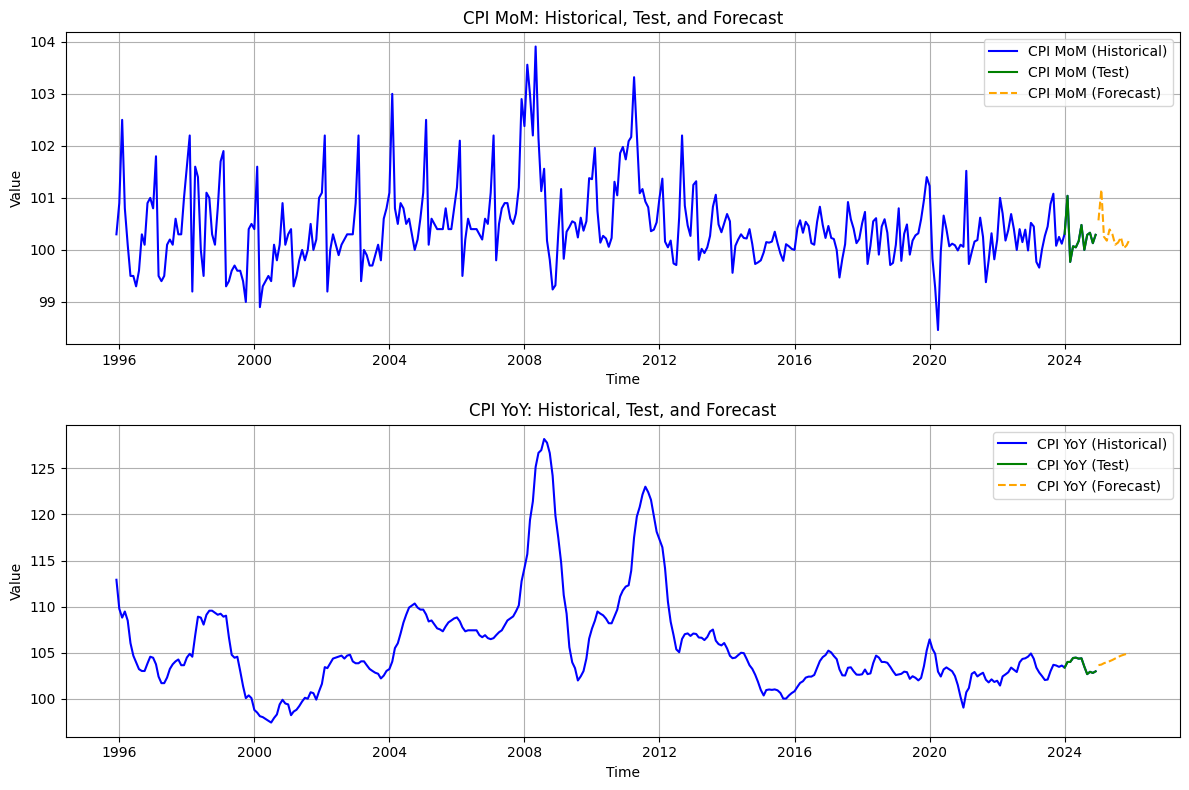

In [19]:
# 11. Dự báo với Exponential Smoothing
# Chia tập train/test
train_mom = df['cpi_mom'][:-12]
test_mom = df['cpi_mom'][-12:]
train_yoy = df['cpi_yoy'][:-12]
test_yoy = df['cpi_yoy'][-12:]

# Dự báo cho cpi_mom
model_mom = ExponentialSmoothing(train_mom, seasonal='add', seasonal_periods=12).fit()
forecast_mom = model_mom.forecast(12)
rmse_mom = np.sqrt(((forecast_mom - test_mom) ** 2).mean())
print(f'\nRMSE dự báo CPI MoM: {rmse_mom:.4f}')

# Dự báo cho cpi_yoy
model_yoy = ExponentialSmoothing(train_yoy, trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_yoy = model_yoy.forecast(12)
rmse_yoy = np.sqrt(((forecast_yoy - test_yoy) ** 2).mean())
print(f'RMSE dự báo CPI YoY: {rmse_yoy:.4f}')

# Trực quan hóa dự báo
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Historical)', color='blue')
plt.plot(test_mom.index, test_mom, label='CPI MoM (Test)', color='green')
plt.plot(forecast_index, forecast_mom, label='CPI MoM (Forecast)', color='orange', linestyle='--')
plt.title('CPI MoM: Historical, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Historical)', color='blue')
plt.plot(test_yoy.index, test_yoy, label='CPI YoY (Test)', color='green')
plt.plot(forecast_index, forecast_yoy, label='CPI YoY (Forecast)', color='orange', linestyle='--')
plt.title('CPI YoY: Historical, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_preliminary_forecast.png')

- CPI MoM: Dự báo (RMSE 0.2461) khá sát với dữ liệu test, cho thấy mô hình Exponential Smoothing hiệu quả.

- CPI YoY: Dự báo (RMSE 1.1998) kém hơn, với sai số lớn ở các đỉnh cao (2008-2011), cần mô hình tốt hơn.

RMSE SARIMA CPI MoM: 0.1885
RMSE SARIMA CPI YoY: 0.2592


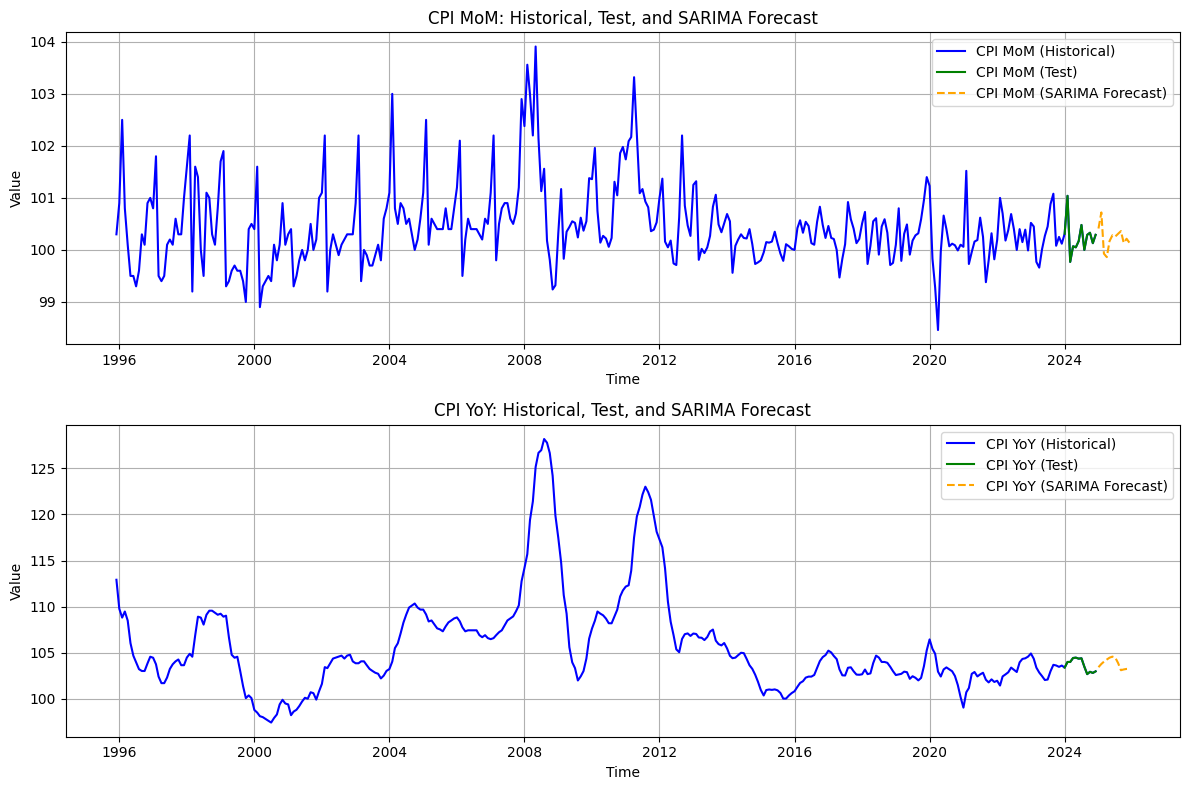

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

# SARIMA cho cpi_mom
# cpi_mom là chuỗi dừng (ADF p-value 0.0028), có mùa vụ, chọn order=(1,0,1), seasonal_order=(1,0,1,12)
model_sarima_mom = SARIMAX(train_mom, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()
forecast_sarima_mom = model_sarima_mom.forecast(12)
rmse_sarima_mom = np.sqrt(((forecast_sarima_mom - test_mom) ** 2).mean())
print(f'RMSE SARIMA CPI MoM: {rmse_sarima_mom:.4f}')

# SARIMA cho cpi_yoy
# cpi_yoy cần sai phân cấp 1 (ADF p-value sau sai phân 0.0000), chọn order=(1,1,1), seasonal_order=(1,0,1,12)
model_sarima_yoy = SARIMAX(train_yoy, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()
forecast_sarima_yoy = model_sarima_yoy.forecast(12)
rmse_sarima_yoy = np.sqrt(((forecast_sarima_yoy - test_yoy) ** 2).mean())
print(f'RMSE SARIMA CPI YoY: {rmse_sarima_yoy:.4f}')

# Trực quan hóa dự báo SARIMA
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')

plt.figure(figsize=(12, 8))

# CPI MoM
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Historical)', color='blue')
plt.plot(test_mom.index, test_mom, label='CPI MoM (Test)', color='green')
plt.plot(forecast_index, forecast_sarima_mom, label='CPI MoM (SARIMA Forecast)', color='orange', linestyle='--')
plt.title('CPI MoM: Historical, Test, and SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# CPI YoY
plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Historical)', color='blue')
plt.plot(test_yoy.index, test_yoy, label='CPI YoY (Test)', color='green')
plt.plot(forecast_index, forecast_sarima_yoy, label='CPI YoY (SARIMA Forecast)', color='orange', linestyle='--')
plt.title('CPI YoY: Historical, Test, and SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('img/cpi_sarima_forecast.png')
plt.show()

CPI MoM:
- RMSE giảm từ 0.2461 xuống 0.1885, cho thấy SARIMA (order=(1,0,1), seasonal_order=(1,0,1,12)) hiệu quả hơn Exponential Smoothing trong việc tận dụng tính mùa vụ và tự tương quan.

CPI YoY:
- RMSE giảm từ 1.1998 xuống 0.2592, là cải tiến lớn. Điều này chứng minh SARIMA (order=(1,1,1), seasonal_order=(1,0,1,12)) phù hợp với chuỗi cần sai phân và yếu tố mùa vụ.

In [27]:
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt

# Tối ưu SARIMA cho cpi_mom với auto_arima
# cpi_mom: chuỗi dừng (d=0), mùa vụ 12 tháng
auto_model_mom = pm.auto_arima(
    train_mom,
    seasonal=True,
    m=12,  # Chu kỳ mùa vụ 12 tháng
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=0,  # Chuỗi dừng, không cần sai phân
    trace=True,  # In chi tiết quá trình tìm kiếm
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("Best SARIMA model for CPI MoM:", auto_model_mom.summary())

# Dự báo và tính RMSE cho cpi_mom
forecast_auto_mom = auto_model_mom.predict(n_periods=12)
rmse_auto_mom = np.sqrt(((forecast_auto_mom - test_mom) ** 2).mean())
print(f'RMSE Auto-SARIMA CPI MoM: {rmse_auto_mom:.4f}')

# Tối ưu SARIMA cho cpi_yoy với auto_arima
# cpi_yoy: cần sai phân (d=1), mùa vụ 12 tháng
auto_model_yoy = pm.auto_arima(
    train_yoy,
    seasonal=True,
    m=12,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,  # Chuỗi cần sai phân cấp 1
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("Best SARIMA model for CPI YoY:", auto_model_yoy.summary())

# Dự báo và tính RMSE cho cpi_yoy
forecast_auto_yoy = auto_model_yoy.predict(n_periods=12)
rmse_auto_yoy = np.sqrt(((forecast_auto_yoy - test_yoy) ** 2).mean())
print(f'RMSE Auto-SARIMA CPI YoY: {rmse_auto_yoy:.4f}')

# Trực quan hóa dự báo
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')

plt.figure(figsize=(12, 8))

# CPI MoM
plt.subplot(2, 1, 1)
plt.plot(df['cpi_mom'], label='CPI MoM (Historical)', color='blue')
plt.plot(test_mom.index, test_mom, label='CPI MoM (Test)', color='green')
plt.plot(forecast_index, forecast_auto_mom, label='CPI MoM (Auto-SARIMA Forecast)', color='orange', linestyle='--')
plt.title('CPI MoM: Historical, Test, and Auto-SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# CPI YoY
plt.subplot(2, 1, 2)
plt.plot(df['cpi_yoy'], label='CPI YoY (Historical)', color='blue')
plt.plot(test_yoy.index, test_yoy, label='CPI YoY (Test)', color='green')
plt.plot(forecast_index, forecast_auto_yoy, label='CPI YoY (Auto-SARIMA Forecast)', color='orange', linestyle='--')
plt.title('CPI YoY: Historical, Test, and Auto-SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('img/cpi_auto_sarima_forecast.png')
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject